In [34]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('assignment3data.csv', parse_dates=['date'], index_col='date')
df.fillna(method='ffill', inplace=True)  # 前向填充缺失值
# 对风向进行独热编码
df = pd.get_dummies(df, columns=['wnd_dir'], prefix='wind')
target = df['pollution'].values
features = df.drop('pollution', axis=1).values

# 标准化特征
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

C:\Users\16323\AppData\Local\Temp\ipykernel_11280\802693759.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # 前向填充缺失值


In [35]:
def create_sequences(features, target, n_steps=3):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i+n_steps]) 
        y.append(target[i+n_steps])    
    return np.array(X), np.array(y)

n_steps = 4  # 时间窗口大小
X, y = create_sequences(scaled_features, target, n_steps)
split = int(0.8 * len(X))# 80%训练集，20%测试集
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [36]:

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建数据集和数据加载器
batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True  # 输入形状为 (batch, seq_len, features)
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)          # 输出形状: (batch, seq_len, hidden_size)
        out = out[:, -1, :]            # 取最后一个时间步的输出
        out = self.dropout(out)
        out = self.linear(out)         # 输出形状: (batch, output_size)
        return out

# 初始化模型
input_size = X_train.shape[2]  # 特征数量
hidden_size = 50
model = LSTMModel(input_size, hidden_size)
print(model)

LSTMModel(
  (lstm): LSTM(10, 50, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [38]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练参数
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
#记录每个epoch的损失
train_losses = []
test_losses = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # 新增：累计每个epoch的训练损失
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_X.size(0)  # 累计损失
    
    # 计算每个epoch的平均训练损失
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)  # 保存训练损失
    
    # 验证集损失
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_loss += criterion(outputs.squeeze(), batch_y).item() * batch_X.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)  # 保存测试损失
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/50], Train Loss: 8243.8207, Test Loss: 6627.6521
Epoch [2/50], Train Loss: 5888.4339, Test Loss: 6053.1784
Epoch [2/50], Train Loss: 5888.4339, Test Loss: 6053.1784
Epoch [3/50], Train Loss: 5537.5813, Test Loss: 5757.3037
Epoch [3/50], Train Loss: 5537.5813, Test Loss: 5757.3037
Epoch [4/50], Train Loss: 5398.9865, Test Loss: 5960.2748
Epoch [4/50], Train Loss: 5398.9865, Test Loss: 5960.2748
Epoch [5/50], Train Loss: 5288.4981, Test Loss: 5903.8336
Epoch [5/50], Train Loss: 5288.4981, Test Loss: 5903.8336
Epoch [6/50], Train Loss: 5233.5832, Test Loss: 5667.2346
Epoch [6/50], Train Loss: 5233.5832, Test Loss: 5667.2346
Epoch [7/50], Train Loss: 5180.9790, Test Loss: 5788.9004
Epoch [7/50], Train Loss: 5180.9790, Test Loss: 5788.9004
Epoch [8/50], Train Loss: 5132.4412, Test Loss: 5652.2372
Epoch [8/50], Train Loss: 5132.4412, Test Loss: 5652.2372
Epoch [9/50], Train Loss: 5048.2057, Test Loss: 5821.0235
Epoch [9/50], Train Loss: 5048.2057, Test Loss: 5821.0235
Epoch [10/50],

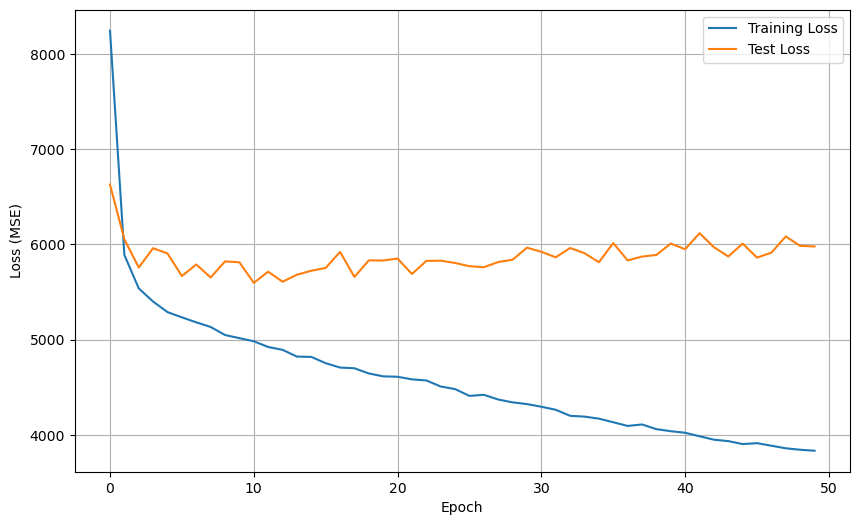

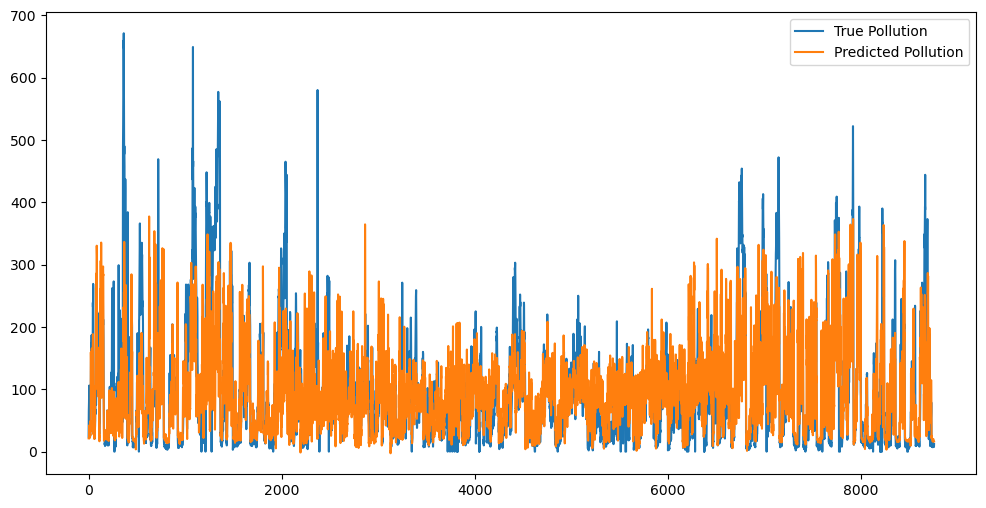

Mean Squared Error: 5978.04


In [39]:
import matplotlib.pyplot as plt
# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
model.eval()
y_pred = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        y_pred.extend(outputs.cpu().numpy().squeeze())

y_pred = np.array(y_pred)
y_test_np = y_test  # 原始目标值
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label='True Pollution')
plt.plot(y_pred, label='Predicted Pollution')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_np, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

In [40]:
# 检查是否有 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 将 LSTM 模型移动到 GPU
model.to(device)
# 改进后的LSTM模型，添加批量归一化和调整dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, dropout_rate=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.bn = nn.BatchNorm1d(hidden_size)  # 批量归一化
        self.dropout = nn.Dropout(dropout_rate)  # 增加dropout率
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # 取最后一个时间步的输出
        out = self.bn(out)   # 应用批量归一化
        out = self.dropout(out)
        out = self.linear(out)
        return out

# 改进后的GRU模型，添加批量归一化和调整dropout
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, dropout_rate=0.3):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)  # 批量归一化
        self.dropout = nn.Dropout(dropout_rate)  # 增加dropout率
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # 取最后一个时间步的输出
        out = self.bn(out)   # 应用批量归一化
        out = self.dropout(out)
        out = self.linear(out)
        return out

# 改进后的Transformer模型，添加批量归一化和调整dropout
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_heads, hidden_size, num_layers, output_size=1, dropout_rate=0.3):
        super(TransformerModel, self).__init__()
        # 确保d_model能被num_heads整除
        self.d_model = num_heads * ((input_size + num_heads - 1) // num_heads)
        self.input_proj = nn.Linear(input_size, self.d_model)
        
        # 在Transformer中添加dropout参数
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model, 
            nhead=num_heads, 
            dim_feedforward=hidden_size,
            dropout=dropout_rate  # 在Transformer内部增加dropout
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.bn = nn.BatchNorm1d(self.d_model)  # 批量归一化
        self.dropout = nn.Dropout(dropout_rate)  # 额外的dropout层
        self.linear = nn.Linear(self.d_model, output_size)

    def forward(self, x):
        x = self.input_proj(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, d_model)
        out = self.transformer(x)
        out = out[-1, :, :]     # 取最后一个时间步的输出
        out = self.bn(out)      # 应用批量归一化
        out = self.dropout(out)
        out = self.linear(out)
        return out
# 初始化 GRU 和 Transformer 模型
gru_model = GRUModel(input_size=X_train.shape[2], hidden_size=50, output_size=1).to(device)
transformer_model = TransformerModel(input_size=X_train.shape[2], num_heads=4, hidden_size=128, num_layers=2, output_size=1).to(device)

# 修改训练函数，添加L2正则化（权重衰减）
def train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.005, weight_decay=1e-5):
    criterion = nn.MSELoss()
    # 添加weight_decay参数实现L2正则化
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 前向传播
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * batch_X.size(0)

        # 计算平均训练损失
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # 验证集损失
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                test_loss += criterion(outputs.squeeze(), batch_y).item() * batch_X.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# 训练 LSTM 模型
print("Training LSTM Model...")
lstm_train_losses, lstm_test_losses = train_model(model, train_loader, test_loader)

# 训练 GRU 模型
print("Training GRU Model...")
gru_train_losses, gru_test_losses = train_model(gru_model, train_loader, test_loader)

# 训练 Transformer 模型
print("Training Transformer Model...")
transformer_train_losses, transformer_test_losses = train_model(transformer_model, train_loader, test_loader)


Using device: cuda
Training LSTM Model...


d:\anaconda\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/30], Train Loss: 3580.2818, Test Loss: 5980.6787
Epoch [2/30], Train Loss: 3460.2657, Test Loss: 6092.7036
Epoch [2/30], Train Loss: 3460.2657, Test Loss: 6092.7036
Epoch [3/30], Train Loss: 3394.2711, Test Loss: 6169.7945
Epoch [3/30], Train Loss: 3394.2711, Test Loss: 6169.7945
Epoch [4/30], Train Loss: 3384.1127, Test Loss: 6138.0768
Epoch [4/30], Train Loss: 3384.1127, Test Loss: 6138.0768
Epoch [5/30], Train Loss: 3394.0746, Test Loss: 6214.8906
Epoch [5/30], Train Loss: 3394.0746, Test Loss: 6214.8906
Epoch [6/30], Train Loss: 3351.7159, Test Loss: 6129.2533
Epoch [6/30], Train Loss: 3351.7159, Test Loss: 6129.2533
Epoch [7/30], Train Loss: 3321.1941, Test Loss: 6122.4736
Epoch [7/30], Train Loss: 3321.1941, Test Loss: 6122.4736
Epoch [8/30], Train Loss: 3298.6213, Test Loss: 6100.1999
Epoch [8/30], Train Loss: 3298.6213, Test Loss: 6100.1999
Epoch [9/30], Train Loss: 3267.5853, Test Loss: 6202.4028
Epoch [9/30], Train Loss: 3267.5853, Test Loss: 6202.4028
Epoch [10/30],

In [42]:
from sklearn.metrics import r2_score

# 计算各模型的R²值
lstm_r2 = r2_score(lstm_y_true, lstm_y_pred)
gru_r2 = r2_score(gru_y_true, gru_y_pred)
transformer_r2 = r2_score(transformer_y_true, transformer_y_pred)

print(f"LSTM模型 R² : {lstm_r2:.4f}")
print(f"GRU模型 R² : {gru_r2:.4f}")
print(f"Transformer模型 R² : {transformer_r2:.4f}")

LSTM模型 R² : 0.2596
GRU模型 R² : 0.3504
Transformer模型 R² : 0.3276
